In [1]:
from src.hrv_epatch.io.labview import read_labview_rr, read_header_datetime_lvm
from src.hrv_epatch.io.data_loader import  Load_full_ecg_data
import pandas as pd
from datetime import datetime
import neurokit2 as nk
import numpy as np
from typing import List, Tuple, Dict, Optional
from dataclasses import dataclass

@dataclass
class SeizureEvent:
    seizure_id: int
    t0: float       # sekunder fra recording start
    t1: float       # sekunder fra recording start


In [ ]:
path_lvm = r"E:\ML algoritme tl anfaldsdetektion vha HRV\LabView-Results\Patient5_1-Res1.lvm"
# path_lvm_croped1 = r"E:\ML algoritme tl anfaldsdetektion vha HRV\LabView-Results\Patient5_remove_s35_e30.lvm"
# path_lvm_croped2 = r"E:\ML algoritme tl anfaldsdetektion vha HRV\LabView-Results\Patient5_remove_s45_e30.lvm"
rr_intervals_lv = read_labview_rr(path_lvm)
starttime_lv = read_header_datetime_lvm(path_lvm)
print(f"Read {len(rr_intervals_lv)} LabVIEW RR intervals from LVM.")
print(f"LabVIEW start time from LVM header: {starttime_lv}")

Read 170108 LabVIEW RR intervals from LVM.
LabVIEW start time from LVM header: 2016-10-12 11:10:19.567329


In [3]:
res = Load_full_ecg_data("Patient 5")
seizure_df = res["Seizures"]
print(res.keys())

[DEBUG] Potentielle annoteringsfiler for Patient 5:
    Patient 5.xls
  - Læser seizure-log fra: E:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Seizure log ePatch patients with seizures - excluded seizures removed\Patient 5.xls
dict_keys(['PatientID', 'ECG', 'Seizures', 'SampleRate', 'StartTime', 'TdmsPath'])


In [4]:
time_to_drop_end = 300  # seconds in both start and end of signal
time_to_drop_start = starttime_lv.timestamp() - res['StartTime'].timestamp()
print(f"Time to drop at start based on LabVIEW start time: {time_to_drop_start} seconds")
fs = res['SampleRate']
starttime_tdms = res['StartTime']
print(f"ECG start time from TDMS: {starttime_tdms}")
samples_to_drop_start = int(time_to_drop_start * fs)  # Convert to integer
samples_to_drop_end = int(time_to_drop_end * fs)
print(f"Dropping {samples_to_drop_start} samples from start and {samples_to_drop_end} samples from end of ECG signal")
ecg = res['ECG'].iloc[samples_to_drop_start:-samples_to_drop_end]
print(f"ECG length before dropping: {len(res['ECG'])} samples")
print(f"ECG length after dropping: {len(ecg)} samples")
corrected_starttime_tdms = starttime_tdms + pd.Timedelta(seconds=time_to_drop_start)
print(f"Corrected ECG start time: {corrected_starttime_tdms}")

Time to drop at start based on LabVIEW start time: 317.5673289299011 seconds
ECG start time from TDMS: 2016-10-12 11:05:02
Dropping 162594 samples from start and 153600 samples from end of ECG signal
ECG length before dropping: 82460288 samples
ECG length after dropping: 82144094 samples
Corrected ECG start time: 2016-10-12 11:10:19.567328


In [5]:


# Extract the ECG signal values
ecg_signal = ecg["Value"].to_numpy()

# Use NeuroKit2 to process the ECG signal and find R-peaks
cleaned_ecg = nk.ecg_clean(ecg_signal, sampling_rate=fs)
r_peaks = nk.ecg_peaks(cleaned_ecg, sampling_rate=fs)[0]

# Display the indices of the detected R-peaks
detected_r_peaks = np.flatnonzero(r_peaks["ECG_R_Peaks"].to_numpy())


In [6]:
print(f"Detected R-peaks: {detected_r_peaks}")
print(f"Number of detected R-peaks: {len(detected_r_peaks)}")

n_dif_rpeaks = len(rr_intervals_lv) - len(detected_r_peaks)
print(f"Difference in number of R-peaks: {n_dif_rpeaks}")

Detected R-peaks: [     546     1483     2745 ... 82140996 82141817 82142979]
Number of detected R-peaks: 167009
Difference in number of R-peaks: 3099


In [7]:
# Convert LabView RR intervals to R-peaks
labview_r_peaks = np.cumsum(np.insert(rr_intervals_lv, 0, 0)) * fs
labview_r_peaks = np.round(labview_r_peaks).astype(int)

# Convert NeuroKit2 detected R-peaks to RR intervals
rr_intervals_detected = np.diff(detected_r_peaks) / fs

# Display the first 10 LabView R-peaks and NeuroKit2 RR intervals
print("First 10 LabView R-peaks (converted from RR intervals):", labview_r_peaks[:10])
print("First 10 NeuroKit2 RR intervals (converted from R-peaks):", rr_intervals_detected[:10])

# Compare the lengths of the two sets of R-peaks
print(f"Number of LabView R-peaks: {len(labview_r_peaks)}")
print(f"Number of NeuroKit2 R-peaks: {len(detected_r_peaks)}")

# Display the first 10 elements of LabView R-peaks and NeuroKit2 detected R-peaks
print("First 10 LabView R-peaks:", labview_r_peaks[:10])
print("First 10 NeuroKit2 detected R-peaks:", detected_r_peaks[:10])

# Display the first 10 elements of LabView RR intervals and NeuroKit2 RR intervals
print("First 10 LabView RR intervals:", rr_intervals_lv[:10])
print("First 10 NeuroKit2 RR intervals:", rr_intervals_detected[:10])

First 10 LabView R-peaks (converted from RR intervals): [   0  372  512  884 1166 1310 1540 1823 2176 2477]
First 10 NeuroKit2 RR intervals (converted from R-peaks): [1.83007812 2.46484375 4.79882812 1.3203125  0.38476562 1.21679688
 1.109375   0.57617188 3.95898438 0.55664062]
Number of LabView R-peaks: 170109
Number of NeuroKit2 R-peaks: 167009
First 10 LabView R-peaks: [   0  372  512  884 1166 1310 1540 1823 2176 2477]
First 10 NeuroKit2 detected R-peaks: [ 546 1483 2745 5202 5878 6075 6698 7266 7561 9588]
First 10 LabView RR intervals: [0.726296 0.273202 0.726915 0.550587 0.281588 0.449085 0.552133 0.691101
 0.587216 0.586223]
First 10 NeuroKit2 RR intervals: [1.83007812 2.46484375 4.79882812 1.3203125  0.38476562 1.21679688
 1.109375   0.57617188 3.95898438 0.55664062]


In [8]:
print(fs)

1.13867188*fs

512.0


583.00000256

In [9]:
# Ensure both arrays have the same length for comparison
min_length = min(len(detected_r_peaks), len(labview_r_peaks))
aligned_detected_r_peaks = detected_r_peaks[:min_length]
aligned_labview_r_peaks = labview_r_peaks[:min_length]

# Calculate the absolute difference in R-peak placement
r_peak_differences = np.abs(aligned_detected_r_peaks - aligned_labview_r_peaks)
average_r_peak_mistake = np.mean(r_peak_differences)

# Ensure both RR interval arrays have the same length for comparison
min_length_rr = min(len(rr_intervals_detected), len(rr_intervals_lv))
aligned_rr_intervals_detected = rr_intervals_detected[:min_length_rr]
aligned_rr_intervals_lv = rr_intervals_lv[:min_length_rr]

# Calculate the absolute difference in RR intervals
rr_interval_differences = np.abs(aligned_rr_intervals_detected - aligned_rr_intervals_lv)
average_rr_interval_mistake = np.mean(rr_interval_differences)

# Print the results
print(f"Average mistake in R-peak placement: {average_r_peak_mistake:.2f} samples")
print(f"Average mistake in RR interval length: {average_rr_interval_mistake:.4f} seconds")

Average mistake in R-peak placement: 914759.20 samples
Average mistake in RR interval length: 0.1224 seconds


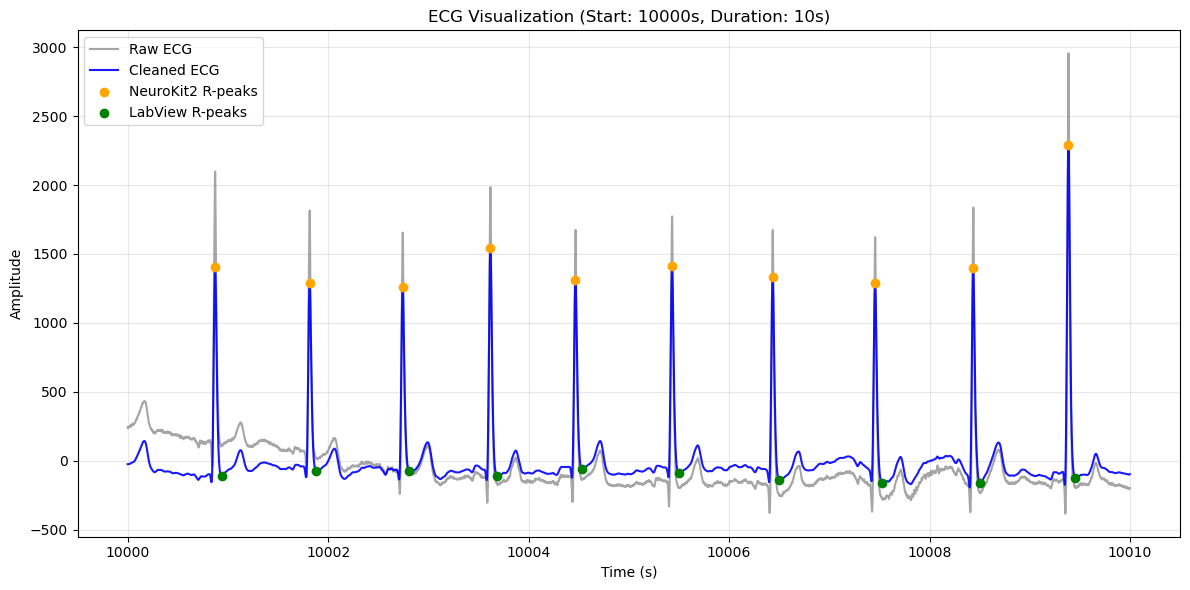

In [10]:
import matplotlib.pyplot as plt

def visualize_ecg_with_r_peaks(
    raw_signal: np.ndarray,
    cleaned_signal: np.ndarray,
    fs: float,
    detected_r_peaks: np.ndarray,
    labview_r_peaks: np.ndarray,
    start_time: float,
    duration: float
):
    """
    Visualize raw ECG, cleaned ECG, and R-peaks from NeuroKit2 and LabView.

    Parameters:
    - raw_signal: Raw ECG signal (numpy array).
    - cleaned_signal: Cleaned ECG signal (numpy array).
    - fs: Sampling frequency (float).
    - detected_r_peaks: R-peaks detected by NeuroKit2 (numpy array).
    - labview_r_peaks: R-peaks from LabView (numpy array).
    - start_time: Start time in seconds for the visualization window (float).
    - duration: Duration in seconds for the visualization window (float).
    """
    start_sample = int(start_time * fs)
    end_sample = int((start_time + duration) * fs)

    # Extract the window of interest
    raw_window = raw_signal[start_sample:end_sample]
    cleaned_window = cleaned_signal[start_sample:end_sample]
    time_axis = np.arange(start_sample, end_sample) / fs

    # Get R-peaks within the window
    detected_r_peaks_window = detected_r_peaks[
        (detected_r_peaks >= start_sample) & (detected_r_peaks < end_sample)
    ] - start_sample
    labview_r_peaks_window = labview_r_peaks[
        (labview_r_peaks >= start_sample) & (labview_r_peaks < end_sample)
    ] - start_sample

    # Plot the signals and R-peaks
    plt.figure(figsize=(12, 6))
    plt.plot(time_axis, raw_window, label="Raw ECG", color="gray", alpha=0.7)
    plt.plot(time_axis, cleaned_window, label="Cleaned ECG", color="blue", alpha=0.9)

    # Plot NeuroKit2 R-peaks
    plt.scatter(
        time_axis[detected_r_peaks_window],
        cleaned_window[detected_r_peaks_window],
        color="orange",
        label="NeuroKit2 R-peaks",
        zorder=3,
    )

    # Plot LabView R-peaks
    plt.scatter(
        time_axis[labview_r_peaks_window],
        cleaned_window[labview_r_peaks_window],
        color="green",
        label="LabView R-peaks",
        zorder=3,
    )

    plt.title(f"ECG Visualization (Start: {start_time}s, Duration: {duration}s)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Example usage
visualize_ecg_with_r_peaks(
    raw_signal=ecg_signal,
    cleaned_signal=cleaned_ecg,
    fs=fs,
    detected_r_peaks=detected_r_peaks,
    labview_r_peaks=labview_r_peaks,
    start_time=10000,  # Adjust the start time as needed
    duration=10      # Adjust the duration as needed
)

In [ ]:
from scipy.signal import correlate, convolve

def event_metrics_overlap_lag(gold_idx: np.ndarray,
                              test_idx: np.ndarray,
                              fs: float,
                              tol_ms: float = 40.0,
                              max_lag_ms: float = 150.0) -> Dict[str, float]:
    """
    Compute TP/FP/FN/Sensitivity/PPV/F1 after cropping to overlap, estimating a small lag
    (±max_lag_ms) and applying a symmetric tolerance window (±tol_ms) around gold peaks.
    """
    gold_idx = np.asarray(gold_idx, dtype=int)
    test_idx = np.asarray(test_idx, dtype=int)

    lo = max(gold_idx.min(), test_idx.min())
    hi = min(gold_idx.max(), test_idx.max())
    if hi <= lo:
        raise ValueError("No temporal overlap between peak sequences.")

    g = gold_idx[(gold_idx >= lo) & (gold_idx < hi)] - lo
    t = test_idx[(test_idx >= lo) & (test_idx < hi)] - lo
    N = int(hi - lo)
    a = np.zeros(N, dtype=np.uint8); a[g] = 1
    b = np.zeros(N, dtype=np.uint8); b[t] = 1

    # find best small lag
    maxlag = int(round(max_lag_ms/1000.0*fs))
    bestlag = 0; best = -1
    for lag in range(-maxlag, maxlag+1):
        if lag < 0:
            score = int((a[:lag] & b[-lag:]).sum())
        elif lag > 0:
            score = int((a[lag:] & b[:-lag]).sum())
        else:
            score = int((a & b).sum())
        if score > best:
            best, bestlag = score, lag

    # shift after best lag
    if bestlag > 0:
        b2 = b[bestlag:]; a2 = a[:len(b2)]
    elif bestlag < 0:
        a2 = a[-bestlag:]; b2 = b[:len(a2)]
    else:
        a2, b2 = a, b

    tol = int(round(tol_ms/1000.0*fs))
    win = np.ones(2*tol+1, dtype=int)
    TP = int((convolve(a2, win, mode='same') * b2 > 0).sum())
    FP = int(int(b2.sum()) - TP)
    FN = int(int(a2.sum()) - TP)

    sens = TP/(TP+FN) if (TP+FN) > 0 else np.nan
    ppv  = TP/(TP+FP) if (TP+FP) > 0 else np.nan
    f1   = 2*sens*ppv/(sens+ppv) if (sens>0 and ppv>0) else np.nan

    return dict(TP=TP, FP=FP, FN=FN, Sensitivity=sens, PPV=ppv, F1=f1,
                lag_samples=bestlag, tol_samples=tol, N_overlap=len(a2), lo=lo, hi=lo+len(a2))

In [13]:
import numpy as np
from typing import Dict, Optional

def match_rpeaks_pairwise(
    gold_idx: np.ndarray,
    test_idx: np.ndarray,
    fs: float,
    tol_ms: float = 40.0,
    known_offset_s: Optional[float] = None,
) -> Dict[str, float]:
    """
    Sammenlign R-peak indekser (gold vs test) med tolerance-vindue.
    
    - gold_idx: 1D array med sample-indekser for 'sandheden' (LabVIEW eller annotator)
    - test_idx: 1D array med sample-indekser for din test-detektor (Android)
    - fs: samplingfrekvens [Hz]
    - tol_ms: tids-tolerance per peak (±tol_ms omkring gold peak)
    - known_offset_s: hvis du ved, at test ligger fx 0.06 s efter gold,
                     så kan du angive det her (positiv værdi => test peaks flyttes tidligere).
    
    Returnerer TP, FP, FN, Sensitivity, PPV, F1 samt lidt ekstra info.
    """
    gold = np.asarray(gold_idx, dtype=int)
    test = np.asarray(test_idx, dtype=int)

    # sortér for en sikkerheds skyld
    gold = np.sort(gold)
    test = np.sort(test)

    # hvis du har et kendt offset (fx LabVIEW ligger ~0.06s foran)
    if known_offset_s is not None:
        offset_samples = int(round(known_offset_s * fs))
        # Hvis LabVIEW er foran, så ligger TEST bagefter tidsmæssigt,
        # dvs. vi vil flytte test-peaks TIDLIGERE:
        test = test - offset_samples

    # begræns til fælles tidsområde (valgfrit, men ofte fornuftigt)
    lo = max(gold.min(), test.min())
    hi = min(gold.max(), test.max())
    gold = gold[(gold >= lo) & (gold <= hi)]
    test = test[(test >= lo) & (test <= hi)]

    tol = int(round(tol_ms / 1000.0 * fs))

    i = 0  # indeks i gold
    j = 0  # indeks i test
    TP = 0
    FN = 0
    matched_test = np.zeros(len(test), dtype=bool)

    # greedy matching
    while i < len(gold) and j < len(test):
        dt = test[j] - gold[i]

        if abs(dt) <= tol:
            # match fundet
            TP += 1
            matched_test[j] = True
            i += 1
            j += 1
        elif test[j] < gold[i] - tol:
            # test-peak ligger for tidligt ift gold[i] og er udenfor tolerance => FP
            j += 1
        else:
            # gold-peak ligger for tidligt ift test[j] og er udenfor tolerance => FN
            FN += 1
            i += 1

    # alt resterende i gold -> FN
    if i < len(gold):
        FN += (len(gold) - i)

    # alt test-peaks der aldrig blev matchet -> FP
    FP = int((~matched_test).sum())

    sens = TP / (TP + FN) if (TP + FN) > 0 else np.nan
    ppv  = TP / (TP + FP) if (TP + FP) > 0 else np.nan
    f1   = 2 * sens * ppv / (sens + ppv) if (sens > 0 and ppv > 0) else np.nan

    return dict(
        TP=TP,
        FP=FP,
        FN=FN,
        Sensitivity=sens,
        PPV=ppv,
        F1=f1,
        N_gold=int(len(gold)),
        N_test=int(len(test)),
        tol_samples=tol,
        lo=lo,
        hi=hi,
    )


In [14]:
# Example usage
# tolerance_ms = 40.0  # Adjust the tolerance as needed
# results = assess_r_peak_detection(
#     detected_r_peaks=detected_r_peaks,
#     labview_r_peaks=labview_r_peaks,
#     fs=fs,
#     tolerance_ms=tolerance_ms
# )

# print(f"Results with tolerance {tolerance_ms} ms:")
# print(f"True Positives (TP): {results['TP']}")
# print(f"False Positives (FP): {results['FP']}")
# print(f"False Negatives (FN): {results['FN']}")
# print(f"True Negatives (TN): {results['TN']}")

print(labview_r_peaks[:10], detected_r_peaks[0:2])

# Print last element from both R-peak arrays (guarded for empty arrays)
if labview_r_peaks.size:
    print("Last LabView R-peak (sample):", int(labview_r_peaks[-1]))
else:
    print("LabView R-peaks is empty")

if detected_r_peaks.size:
    print("Last NeuroKit2 R-peak (sample):", int(detected_r_peaks[-1]))
else:
    print("NeuroKit2 detected R-peaks is empty")

[   0  372  512  884 1166 1310 1540 1823 2176 2477] [ 546 1483]
Last LabView R-peak (sample): 82143415
Last NeuroKit2 R-peak (sample): 82142979


In [15]:
# results = event_metrics_overlap_lag(detected_r_peaks,
#                                    labview_r_peaks,
#                                    fs,
#                                    tol_ms=100.0,
#                                    max_lag_ms=2000.0)

In [16]:
# print("Event metrics with overlap and lag adjustment:")
# print(results)

In [17]:
metrics = match_rpeaks_pairwise(
    gold_idx=labview_r_peaks,
    test_idx=detected_r_peaks,
    fs=512,
    tol_ms=5.0,
    known_offset_s=-0.065,  # flytter ~31 samples tidligere
)
print(metrics)


{'TP': 166390, 'FP': 619, 'FN': 3714, 'Sensitivity': 0.9781662982645911, 'PPV': 0.9962936129190643, 'F1': 0.9871467430802136, 'N_gold': 170104, 'N_test': 167009, 'tol_samples': 3, 'lo': np.int64(579), 'hi': np.int64(82143012)}


In [18]:
metrics = match_rpeaks_pairwise(
    gold_idx=labview_r_peaks,
    test_idx=detected_r_peaks,
    fs=512,
    tol_ms=40.0,
    known_offset_s=-0.065,  # flytter ~31 samples tidligere
)
print(metrics)

{'TP': 166519, 'FP': 490, 'FN': 3585, 'Sensitivity': 0.9789246578563702, 'PPV': 0.9970660263818117, 'F1': 0.9879120650939002, 'N_gold': 170104, 'N_test': 167009, 'tol_samples': 20, 'lo': np.int64(579), 'hi': np.int64(82143012)}


In [19]:
import numpy as np
from typing import Dict, Optional

def match_rpeaks_pairwise_verbose(
    gold_idx: np.ndarray,
    test_idx: np.ndarray,
    fs: float,
    tol_ms: float = 40.0,
    known_offset_s: Optional[float] = None,
) -> Dict[str, float]:
    """
    Samme logik som match_rpeaks_pairwise, men returnerer også
    hvilke peaks der er TP/FP/FN.

    Bemærk:
    - FN_idx_gold er i gold's sample-indekser (altså direkte til plottet).
    - TP/FP test-indekser er i 'test' efter evt. offset-korrektion.
    """
    gold = np.asarray(gold_idx, dtype=int)
    test = np.asarray(test_idx, dtype=int)

    gold = np.sort(gold)
    test = np.sort(test)

    # kendt offset mellem sekvenser (fx LabVIEW foran test)
    if known_offset_s is not None:
        offset_samples = int(round(known_offset_s * fs))
        test = test - offset_samples

    # fælles tidsinterval
    lo = max(gold.min(), test.min())
    hi = min(gold.max(), test.max())
    gold = gold[(gold >= lo) & (gold <= hi)]
    test = test[(test >= lo) & (test <= hi)]

    tol = int(round(tol_ms / 1000.0 * fs))

    i = 0
    j = 0
    TP = 0
    FN = 0
    matched_test = np.zeros(len(test), dtype=bool)
    matched_gold = np.zeros(len(gold), dtype=bool)

    # greedy matching
    while i < len(gold) and j < len(test):
        dt = test[j] - gold[i]

        if abs(dt) <= tol:
            TP += 1
            matched_test[j] = True
            matched_gold[i] = True
            i += 1
            j += 1
        elif test[j] < gold[i] - tol:
            j += 1
        else:
            FN += 1
            matched_gold[i] = False
            i += 1

    # resterende gold -> FN
    if i < len(gold):
        FN += (len(gold) - i)

    # resterende test -> FP
    FP = int((~matched_test).sum())

    sens = TP / (TP + FN) if (TP + FN) > 0 else np.nan
    ppv  = TP / (TP + FP) if (TP + FP) > 0 else np.nan
    f1   = 2 * sens * ppv / (sens + ppv) if (sens > 0 and ppv > 0) else np.nan

    # indeks-sæt
    TP_idx_gold = gold[matched_gold]
    FN_idx_gold = gold[~matched_gold]
    TP_idx_test = test[matched_test]
    FP_idx_test = test[~matched_test]

    return dict(
        TP=TP,
        FP=FP,
        FN=FN,
        Sensitivity=sens,
        PPV=ppv,
        F1=f1,
        N_gold=int(len(gold)),
        N_test=int(len(test)),
        tol_samples=tol,
        lo=lo,
        hi=hi,
        TP_idx_gold=TP_idx_gold,
        FN_idx_gold=FN_idx_gold,
        TP_idx_test=TP_idx_test,
        FP_idx_test=FP_idx_test,
    )


In [20]:
def estimate_lag_samples(gold_idx, test_idx, fs, tol_ms=40.0, max_lag_ms=150.0):
    """
    Brug din eksisterende event_metrics_overlap_lag til at estimere lag (i samples)
    mellem gold_idx og test_idx.
    """
    res = event_metrics_overlap_lag(
        gold_idx=gold_idx,
        test_idx=test_idx,
        fs=fs,
        tol_ms=tol_ms,
        max_lag_ms=max_lag_ms,
    )
    return res["lag_samples"], res

def match_rpeaks_pairwise_verbose_auto(
    gold_idx: np.ndarray,
    test_idx: np.ndarray,
    fs: float,
    tol_ms: float = 40.0,
    max_lag_ms: float = 150.0,
):
    """
    - Estimerer først lag via event_metrics_overlap_lag
    - Shifter test-peaks så de aligner med gold
    - Croper til fælles tidsinterval
    - Laver greedy pairwise matching og returnerer TP/FP/FN + index-lister
    """
    gold = np.sort(np.asarray(gold_idx, dtype=int))
    test = np.sort(np.asarray(test_idx, dtype=int))

    # 1) Estimér lag (i samples) med din gamle funktion
    bestlag, _ = estimate_lag_samples(gold, test, fs, tol_ms, max_lag_ms)
    # Samme konvention som i event_metrics_overlap_lag:
    # bestlag > 0 betyder, at vi skal flytte test-peaks TIDLIGERE i tid
    test_aligned = test - int(bestlag)

    # 2) Crop til fælles område
    lo = max(gold.min(), test_aligned.min())
    hi = min(gold.max(), test_aligned.max())
    if hi <= lo:
        raise ValueError("No temporal overlap between aligned peak sequences.")

    gold = gold[(gold >= lo) & (gold <= hi)]
    test_aligned = test_aligned[(test_aligned >= lo) & (test_aligned <= hi)]

    # 3) Greedy matching med tolerance
    tol = int(round(tol_ms / 1000.0 * fs))
    i, j = 0, 0
    matched_gold = np.zeros(len(gold), dtype=bool)
    matched_test = np.zeros(len(test_aligned), dtype=bool)

    while i < len(gold) and j < len(test_aligned):
        dt = test_aligned[j] - gold[i]

        if abs(dt) <= tol:
            matched_gold[i] = True
            matched_test[j] = True
            i += 1
            j += 1
        elif test_aligned[j] < gold[i] - tol:
            j += 1
        else:
            i += 1

    TP_idx_test = test_aligned[matched_test]
    FP_idx_test = test_aligned[~matched_test]
    FN_idx_gold = gold[~matched_gold]

    TP, FP, FN = len(TP_idx_test), len(FP_idx_test), len(FN_idx_gold)
    sens = TP / (TP + FN) if (TP + FN) > 0 else np.nan
    ppv  = TP / (TP + FP) if (TP + FP) > 0 else np.nan
    f1   = 2*sens*ppv/(sens+ppv) if (sens>0 and ppv>0) else np.nan

    return dict(
        TP=TP, FP=FP, FN=FN,
        Sensitivity=sens, PPV=ppv, F1=f1,
        TP_idx_test=TP_idx_test,
        FP_idx_test=FP_idx_test,
        FN_idx_gold=FN_idx_gold,
        tol_samples=tol,
        lag_samples=int(bestlag),
        lo=lo,
        hi=hi,
    )

def plot_FN_over_signal_light(FN_idx, seizure_windows, fs):
    """
    Plot FN som lodrette streger i tid (sekunder),
    uden at allokere en kæmpe 0/1-array over hele signalet.
    """
    FN_idx = np.asarray(FN_idx, dtype=int)
    t_FN = FN_idx / fs

    plt.figure(figsize=(15, 3))
    plt.vlines(t_FN, 0, 1, lw=0.5, label="FN")

    for s, e in seizure_windows:
        plt.axvspan(s / fs, e / fs, color="orange", alpha=0.3)

    plt.yticks([])
    plt.xlabel("Time [s]")
    plt.title("FN locations vs seizures")
    plt.legend()
    plt.tight_layout()
    plt.show()



In [21]:

def plot_FN_regions(ecg, fs, FN_idx, gold_idx, test_idx, window_s=3.0, max_plots=10):
    win = int(window_s * fs)
    FN_idx = np.array(FN_idx)

    for k, fn in enumerate(FN_idx[:max_plots]):
        lo = max(0, fn - win)
        hi = min(len(ecg), fn + win)

        t = np.arange(lo, hi) / fs

        plt.figure(figsize=(12, 4))
        plt.plot(t, ecg[lo:hi], 'k', lw=1)

        # gold peaks in the window
        g = gold_idx[(gold_idx >= lo) & (gold_idx < hi)]
        plt.scatter(g/fs, ecg[g], c='blue', s=25, label='Gold')

        # test peaks in the window
        td = test_idx[(test_idx >= lo) & (test_idx < hi)]
        plt.scatter(td/fs, ecg[td], c='green', s=25, marker='x', label='Test')

        # FN peak
        plt.scatter(fn/fs, ecg[fn], c='red', s=80, marker='o', label='FN (missed)')

        plt.title(f"FN region {k+1}/{min(max_plots,len(FN_idx))}")
        plt.legend()
        plt.show()

        
def FN_in_seizures(FN_idx, seizure_windows):
    inside = []
    outside = []

    for fn in FN_idx:
        hit = False
        for s, e in seizure_windows:
            if s <= fn <= e:
                hit = True
                break
        (inside if hit else outside).append(fn)

    return np.array(inside), np.array(outside)

def FN_near_seizures(FN_idx, seizure_windows, fs, buffer_s=5):
    inside_or_near = []
    far = []

    buf = int(buffer_s * fs)

    for fn in FN_idx:
        hit = False
        for s, e in seizure_windows:
            if (s - buf) <= fn <= (e + buf):
                hit = True
                break
        (inside_or_near if hit else far).append(fn)

    return np.array(inside_or_near), np.array(far)

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def plot_match_regions(
    ecg,
    fs,
    res_verbose,
    window_s: float = 3.0,
    max_plots: int = 6,
    min_time_s: float = 0.0,
):
    """
    Vis lokale udsnit omkring FN-peaks.

    min_time_s: ignorer FN der ligger før denne tid (i sekunder).
    """
    FN_idx = np.asarray(res_verbose["FN_idx_gold"], dtype=int)
    TP_idx_gold = np.asarray(res_verbose["TP_idx_gold"], dtype=int)
    TP_idx_test = np.asarray(res_verbose["TP_idx_test"], dtype=int)
    FP_idx_test = np.asarray(res_verbose["FP_idx_test"], dtype=int)

    # filtrér FN efter minimumstid
    if min_time_s > 0:
        FN_idx = FN_idx[FN_idx / fs >= min_time_s]

    win = int(window_s * fs)

    n_plots = min(max_plots, len(FN_idx))
    for k in range(n_plots):
        fn = FN_idx[k]
        lo = max(0, fn - win)
        hi = min(len(ecg), fn + win)
        t = np.arange(lo, hi) / fs

        plt.figure(figsize=(12, 4))
        plt.plot(t, ecg[lo:hi], 'k', lw=1)

        g_tp = TP_idx_gold[(TP_idx_gold >= lo) & (TP_idx_gold < hi)]
        plt.scatter(g_tp / fs, ecg[g_tp], c='blue', s=30, label='Gold TP')

        g_fn = FN_idx[(FN_idx >= lo) & (FN_idx < hi)]
        plt.scatter(g_fn / fs, ecg[g_fn], c='red', s=60, marker='o', label='Gold FN')

        t_tp = TP_idx_test[(TP_idx_test >= lo) & (TP_idx_test < hi)]
        plt.scatter(t_tp / fs, ecg[t_tp], c='green', s=30, marker='x', label='Test TP')

        t_fp = FP_idx_test[(FP_idx_test >= lo) & (FP_idx_test < hi)]
        plt.scatter(t_fp / fs, ecg[t_fp], c='orange', s=40, marker='x', label='Test FP')

        plt.title(f"Match region {k+1}/{n_plots} – around FN at t={fn/fs:.2f}s")
        plt.legend(loc='upper right')
        plt.tight_layout()
        plt.show()

def plot_FP_FN_overview(res_verbose, fs, seizures=None):
    FN_idx = np.asarray(res_verbose["FN_idx_gold"], dtype=int)
    FP_idx = np.asarray(res_verbose["FP_idx_test"], dtype=int)

    t_FN = FN_idx / fs
    t_FP = FP_idx / fs

    plt.figure(figsize=(15, 3))

    # FP først, halv højde
    if len(t_FP) > 0:
        plt.vlines(t_FP, 0.0, 0.5, lw=0.5,
                   label=f"FP (N={len(t_FP)})", color='orange', alpha=0.8)

    # FN ovenpå, fuld højde
    if len(t_FN) > 0:
        plt.vlines(t_FN, 0.0, 1.0, lw=0.5,
                   label=f"FN (N={len(t_FN)})", color='red', alpha=0.8)

    if seizures is not None:
        for s, e in seizures:
            plt.axvspan(s / fs, e / fs, color='blue', alpha=0.2)

    plt.yticks([])
    plt.xlabel("Time [s]")
    plt.title("Overview of FP and FN locations vs. seizures")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()


def FP_FN_histogram_per_min(res_verbose, fs, record_duration_s=None, bin_s=60):
    FN_idx = np.asarray(res_verbose["FN_idx_gold"], dtype=int)
    FP_idx = np.asarray(res_verbose["FP_idx_test"], dtype=int)

    t_FN = FN_idx / fs
    t_FP = FP_idx / fs

    if record_duration_s is None:
        record_duration_s = max(t_FN.max() if len(t_FN) else 0,
                                t_FP.max() if len(t_FP) else 0)

    bins = np.arange(0, record_duration_s + bin_s, bin_s)

    FN_hist, _ = np.histogram(t_FN, bins=bins)
    FP_hist, _ = np.histogram(t_FP, bins=bins)

    centers = (bins[:-1] + bins[1:]) / 2

    plt.figure(figsize=(12, 4))
    plt.plot(centers / 60, FN_hist, label='FN/min')
    plt.plot(centers / 60, FP_hist, label='FP/min')
    plt.xlabel("Time [min]")
    plt.ylabel("Count per bin")
    plt.title("FP/FN per minute")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [23]:
seizures = [(73315, 73435), (99747, 99862),(102686, 102816)]  # times in samples
print(len(cleaned_ecg))

82144094


TP=166519, FP=490, FN=3585, Sens=0.9789, PPV=0.9971, F1=0.9879
Number of FN peaks: 3585


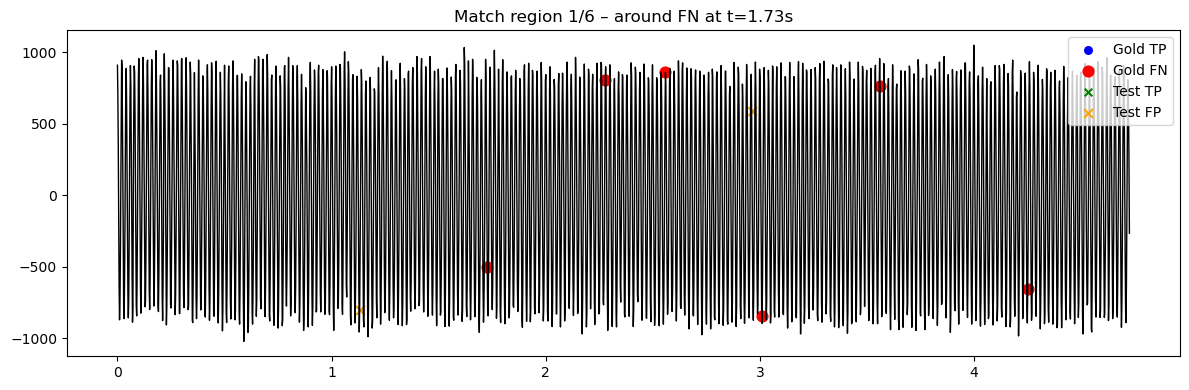

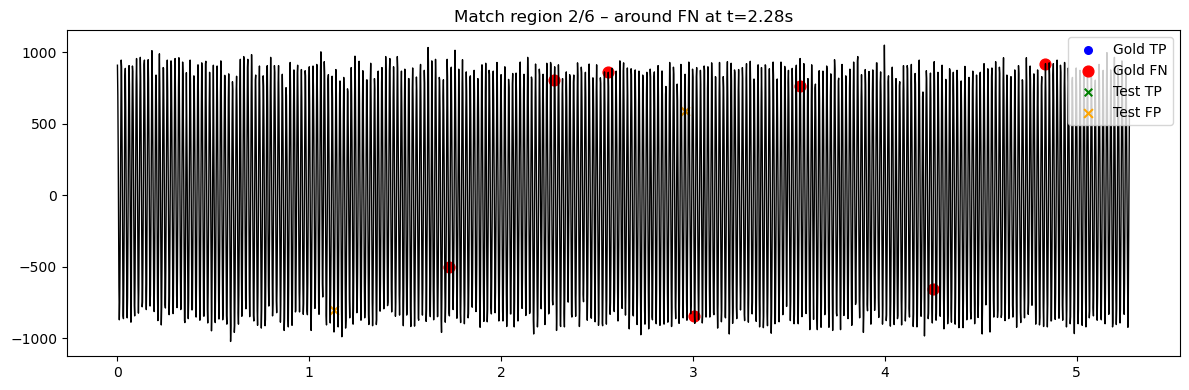

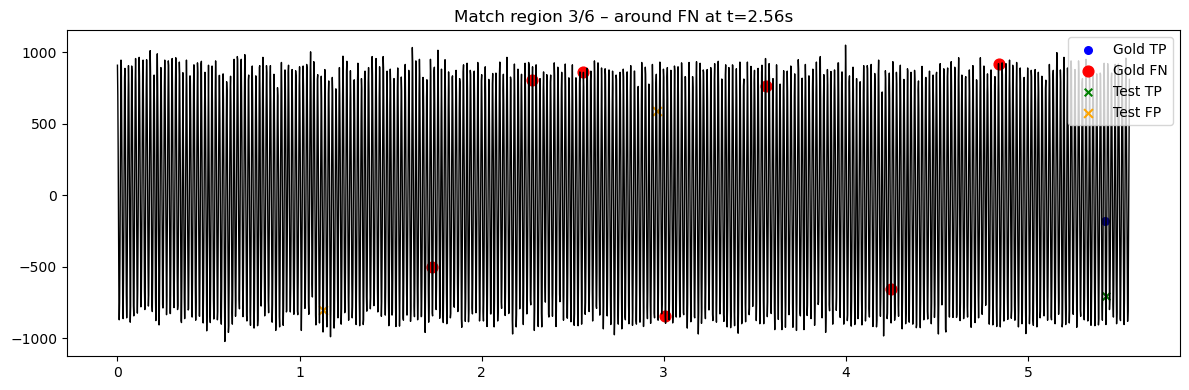

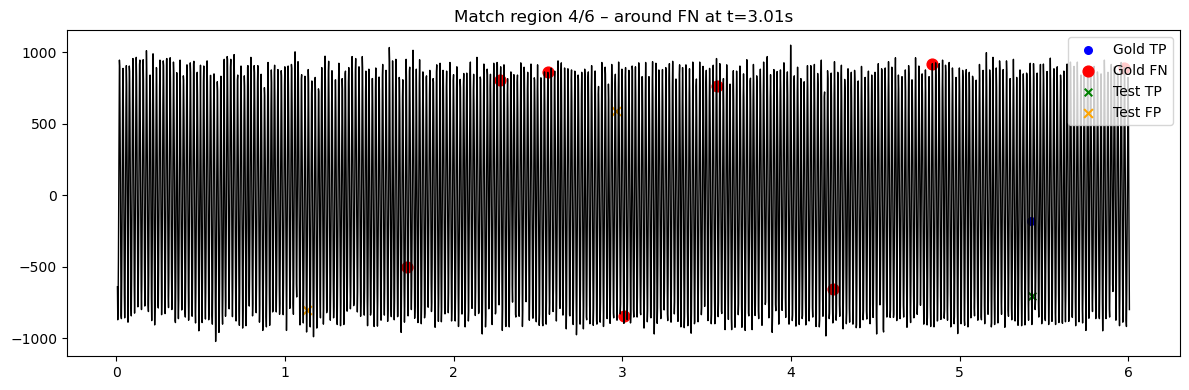

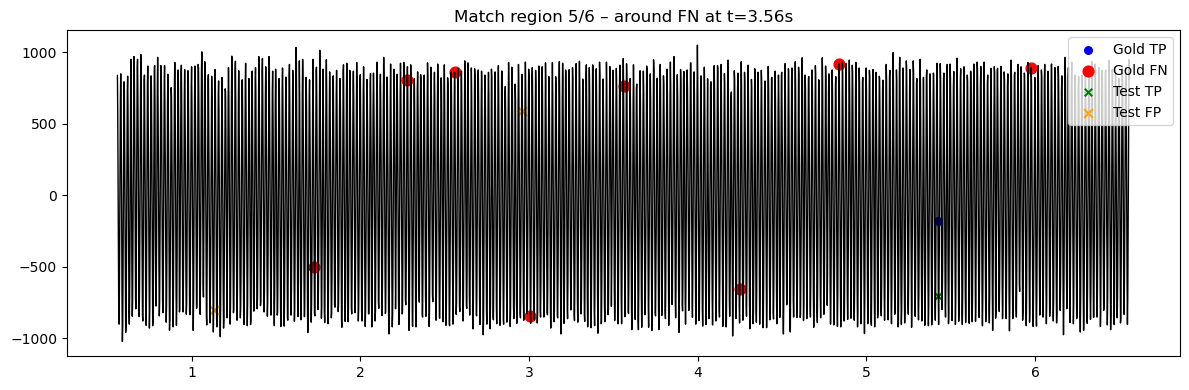

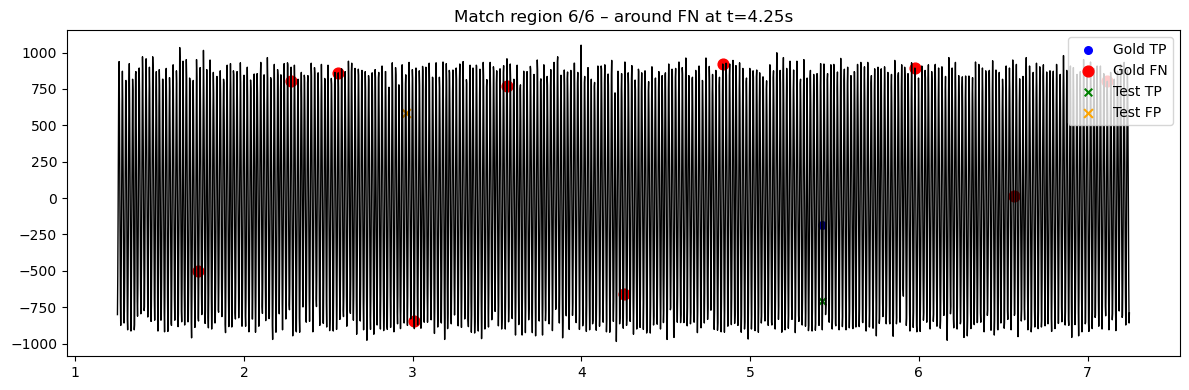

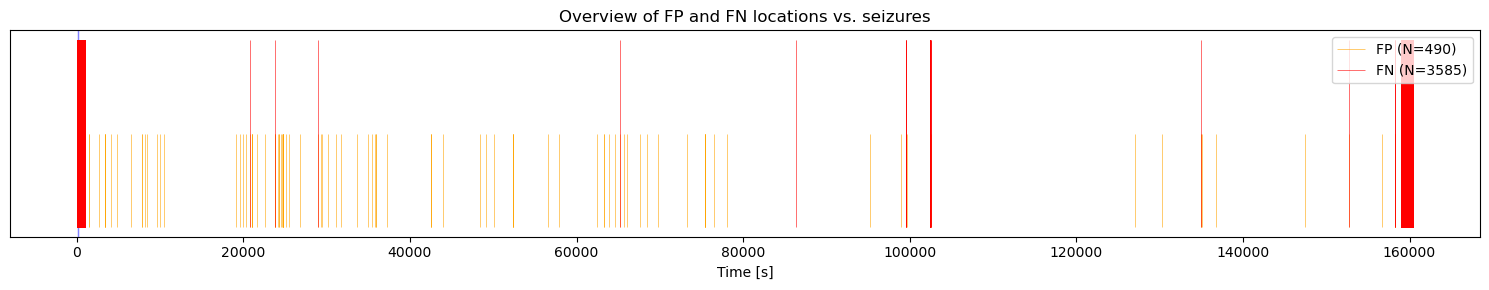

FNs inside seizures: 2
FNs outside seizures: 3583
FNs inside or within 5s of seizures: 76; far from seizures: 3509


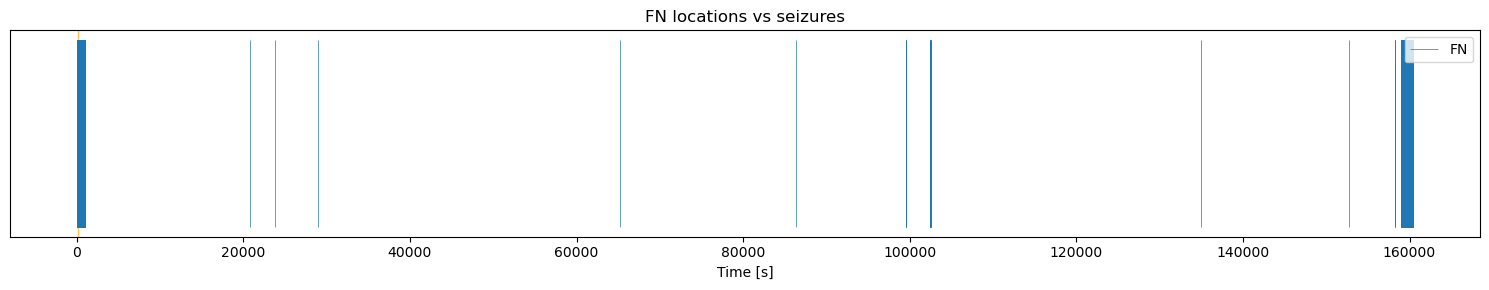

In [25]:
# 1) Matching (brug det offset der gav dig gode resultater før)
res_verbose = match_rpeaks_pairwise_verbose(
    gold_idx=labview_r_peaks,      # eller omvendt, alt efter hvad du kalder 'sandhed'
    test_idx=detected_r_peaks,
    fs=fs,
    tol_ms=40.0,
    known_offset_s=-0.065,          # eller hvad du fandt fungerer
)

print(
    f"TP={res_verbose['TP']}, FP={res_verbose['FP']}, FN={res_verbose['FN']}, "
    f"Sens={res_verbose['Sensitivity']:.4f}, PPV={res_verbose['PPV']:.4f}, F1={res_verbose['F1']:.4f}"
)

# 2) FN-indeks (i gold-koordinater, dvs. direkte til plottet)
FN_idx = res_verbose["FN_idx_gold"]
print(f"Number of FN peaks: {len(FN_idx)}")

# 3) Lokale FN-områder
plot_match_regions(
    ecg=ecg_signal,   # eller cleaned_ecg
    fs=fs,
    res_verbose=res_verbose,
    window_s=3.0,
    max_plots=6,
)

plot_FP_FN_overview(res_verbose, fs=fs, seizures=seizures)
# 4) Relation til anfald (forudsat seizures er i samples)
inside, outside = FN_in_seizures(FN_idx, seizures)
inside_or_near, far = FN_near_seizures(FN_idx, seizures, fs, buffer_s=5)

print(f"FNs inside seizures: {len(inside)}")
print(f"FNs outside seizures: {len(outside)}")
print(f"FNs inside or within 5s of seizures: {len(inside_or_near)}; far from seizures: {len(far)}")

# 5) Globalt overblik – brug den lette version for ikke at crashe
plot_FN_over_signal_light(FN_idx, seizures, fs=fs)


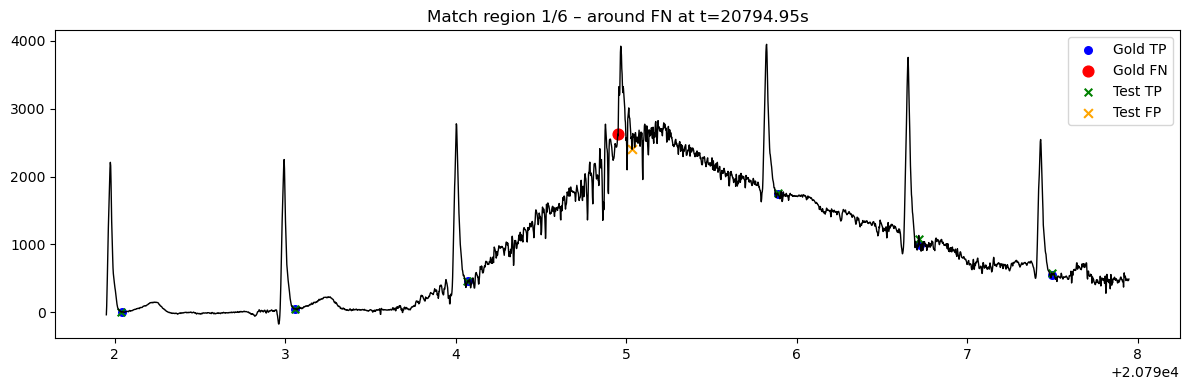

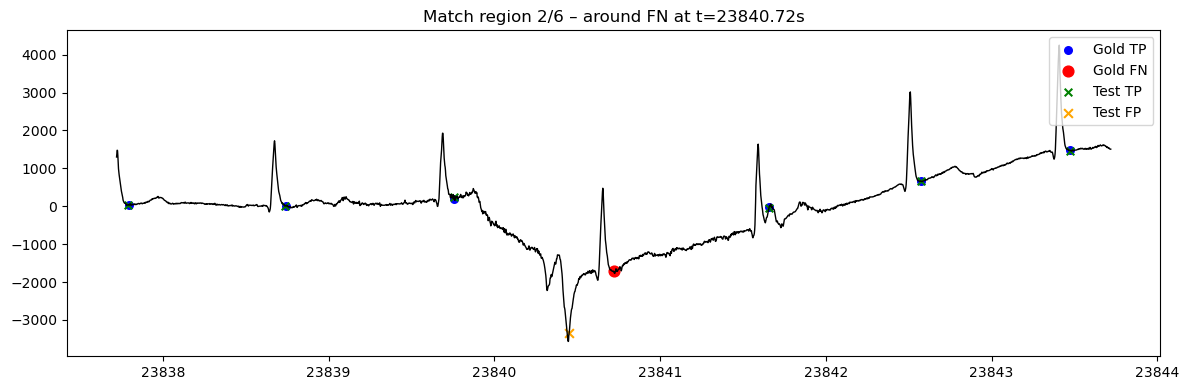

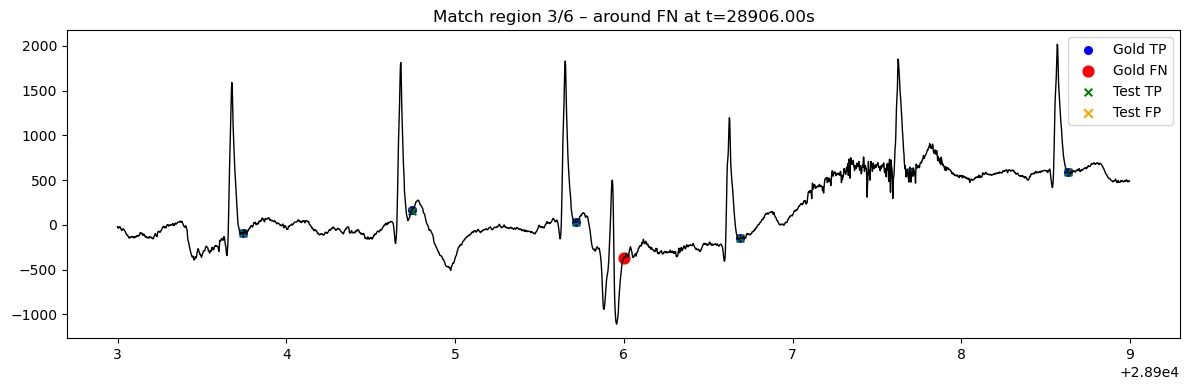

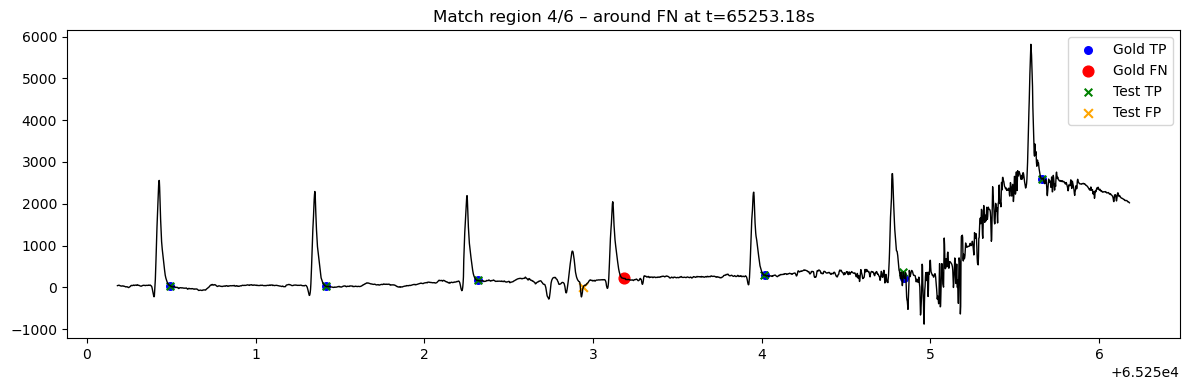

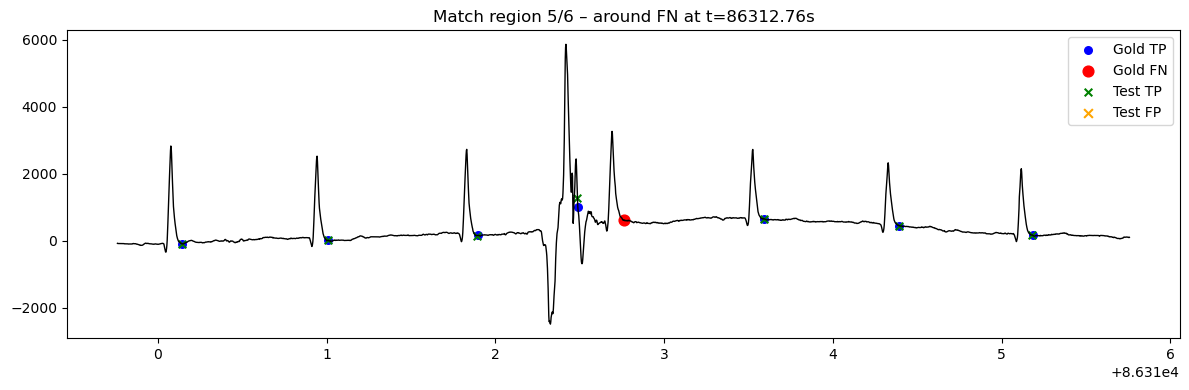

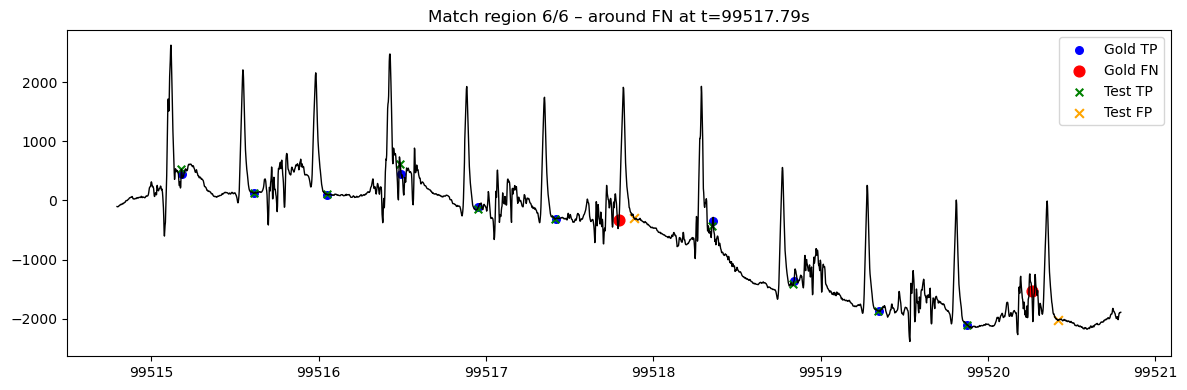

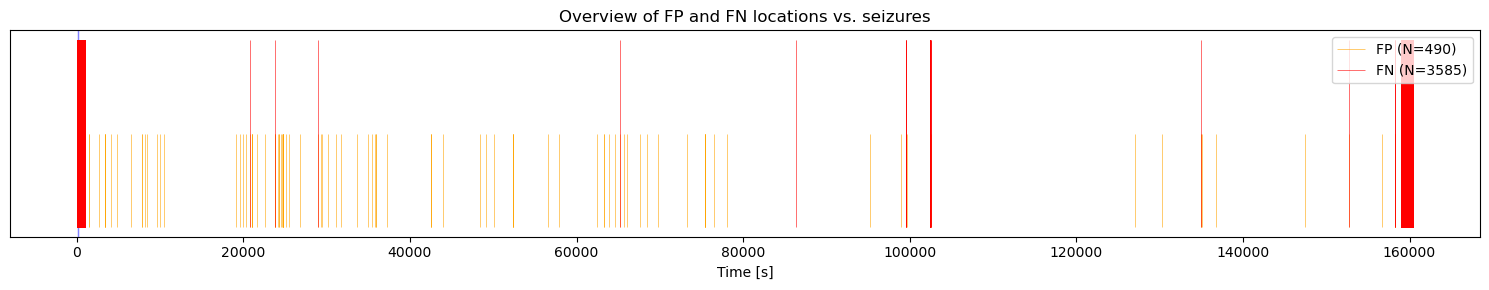

In [26]:
plot_match_regions(
    ecg=ecg_signal,
    fs=fs,
    res_verbose=res_verbose,
    window_s=3.0,
    max_plots=6,
    min_time_s=5000.0,   # kun FN efter 5000 s
)

plot_FP_FN_overview(res_verbose, fs=fs, seizures=seizures)

In [27]:
print(seizures)

[(73315, 73435), (99747, 99862), (102686, 102816)]


In [28]:
# def match_rpeaks_pairwise_verbose(
#     gold_idx: np.ndarray,
#     test_idx: np.ndarray,
#     fs: float,
#     tol_ms: float = 40.0,
#     known_offset_s: Optional[float] = None,
# ):
#     gold = np.sort(np.asarray(gold_idx, dtype=int))
#     test = np.sort(np.asarray(test_idx, dtype=int))

#     # apply known timing offset
#     if known_offset_s is not None:
#         offset_samples = int(round(known_offset_s * fs))
#         test = test - offset_samples

#     # tolerance
#     tol = int(round(tol_ms / 1000.0 * fs))

#     i, j = 0, 0
#     matched_test = np.zeros(len(test), dtype=bool)
#     matched_gold = np.zeros(len(gold), dtype=bool)

#     # greedy matching
#     while i < len(gold) and j < len(test):
#         dt = test[j] - gold[i]

#         if abs(dt) <= tol:
#             matched_test[j] = True
#             matched_gold[i] = True
#             i += 1
#             j += 1
#         elif test[j] < gold[i] - tol:
#             j += 1
#         else:
#             i += 1

#     # extract relevant sets
#     TP_idx_test  = test[matched_test]
#     FP_idx_test  = test[~matched_test]
#     FN_idx_gold  = gold[~matched_gold]

#     # metrics
#     TP, FP, FN = len(TP_idx_test), len(FP_idx_test), len(FN_idx_gold)
#     sens = TP / (TP + FN) if TP + FN > 0 else np.nan
#     ppv  = TP / (TP + FP) if TP + FP > 0 else np.nan
#     f1   = 2*sens*ppv/(sens+ppv) if sens>0 and ppv>0 else np.nan

#     return dict(
#         TP=TP, FP=FP, FN=FN,
#         Sensitivity=sens, PPV=ppv, F1=f1,
#         TP_idx_test=TP_idx_test,
#         FP_idx_test=FP_idx_test,
#         FN_idx_gold=FN_idx_gold,
#         tol_samples=tol,
#     )


# import matplotlib.pyplot as plt
# import numpy as np




# def plot_FN_over_signal(FN_idx, seizure_windows, signal_length, fs):
#     timeline = np.zeros(signal_length)
#     timeline[FN_idx] = 1

#     plt.figure(figsize=(15, 3))
#     plt.plot(timeline, 'r|', markersize=10, label='FN')

#     # mark seizures
#     for s, e in seizure_windows:
#         plt.axvspan(s, e, color='orange', alpha=0.3)

#     plt.title("FN locations vs seizures")
#     plt.legend()
#     plt.tight_layout()
#     plt.show()
